#CSE255 HW1
##Mengqi Yu
##A53077101
##mey004@eng.ucsd.edu

This notebook include 2 approaches to estimate the mean, variance, co-variance and correlation coefficient. The first is the streaming method and the second is the exponential decay estimation method.

In [16]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import lfilter 
%matplotlib inline
from pylab import rcParams

#control the figure size
rcParams['figure.figsize'] = 16, 10

from time import time
import ipython_memory_usage as imu  # the ipython_memory_usage.py is a utility that measures the amount of memory used
imu.start_watching_memory()

In [16] used -1492.0000 MiB RAM in 1.19s, peaked 0.00 MiB above current, total RAM usage 1541.62 MiB
In [16] used -0.0156 MiB RAM in 1.30s, peaked 0.02 MiB above current, total RAM usage 1541.61 MiB


The following method is using a streaming approach which is quite similar to the one taught in the class.

In [2]:
# Using the generator pattern (an iterable)
class run_aver:
    ## Initialize the object
    def __init__(self):
        self.t = 0.0
        self.s = 0.0

    # input: x is the mean of the chunk and tt is current chunk size
    def send(self,x,tt):
        self.s=(x*tt + self.t*self.s)/(self.t+tt)                           
        self.t+=tt
    
    def get_state(self):
        return self.s

# compute the variance of a signal with zero mean
class run_var(object):
    ## Initialize the object
    def __init__(self):
        self.t = 0.0
        self.s = 0.0

    # input: x is the variance of the chunk and tt is current chunk size
    def send(self,x,tt):
        self.s=(x*tt + self.t*self.s)/(self.t+tt)            
        self.t+=tt
    
    def get_variance(self):
        return self.s
    
# compute the co-variance of a signal with zero mean
class run_covar(object):
    ## Initialize the object
    def __init__(self):
        self.t = 0.0
        self.s = 0.0

    #  input: x is the co-variance of the chunk and tt is current chunk size
    def send(self,x,tt):
        self.s=(x*tt + self.t*self.s)/(self.t+tt)                         
        self.t+=tt
    
    def get_covariance(self):
        return self.s

In [2] used 0.1836 MiB RAM in 0.13s, peaked 0.00 MiB above current, total RAM usage 57.49 MiB


In [3]:
# input: chunk_sz is chunk size 
# output: aver1, aver2, fvar1, fvar2 are the mean
# and the variance of 2 sequence. cc is the correlation coefficient
def my_cal_chunk(chunk_sz):
    n=chunk_sz
    f1=open('data1.bin','rb')
    f2=open('data2.bin','rb')
    input1=np.zeros(n)
    input2=np.zeros(n)
    Av1=run_aver()
    Av2=run_aver()
    Var1=run_var()
    Var2=run_var()
    Covar=run_covar()
    while True:
        
        input1=np.fromfile(f1,count=n)
        input2=np.fromfile(f2,count=n)
        sz=np.size(input1)
        if sz<=0:
            break
        m1=np.mean(input1)
        m2=np.mean(input2)
        v1=np.var(input1)
        v2=np.var(input2)
        c=np.cov(input1, input2)
        Av1.send(m1,sz)
        Av2.send(m2,sz)
        Var1.send(v1,sz)
        Var2.send(v2,sz)
        Covar.send(c[0,1],sz)
    aver1=Av1.get_state()
    aver2=Av2.get_state()
    fvar1=Var1.get_variance()
    fvar2=Var2.get_variance()
    std1=math.sqrt(fvar1)
    std2=math.sqrt(fvar2)
    cc=Covar.get_covariance()/(std1*std2)
    return aver1, aver2, fvar1, fvar2, cc

In [3] used 0.1641 MiB RAM in 0.13s, peaked 0.00 MiB above current, total RAM usage 57.65 MiB


In [5]:
print my_cal_chunk(10**4)

(0.00010045778200210721, 0.00010193008358257437, 0.9998491435694118, 0.9998473329868895, 0.49965841143616324)
In [5] used 2.2500 MiB RAM in 2.51s, peaked 0.00 MiB above current, total RAM usage 60.80 MiB


In [4]:
# 10^5 is the best chunk size
print my_cal_chunk(10**5)

(0.00010045778200210712, 0.00010193008358257398, 0.9998944007552646, 0.9998926417729311, 0.49965874223378748)
In [4] used 0.8477 MiB RAM in 2.60s, peaked 4.58 MiB above current, total RAM usage 58.41 MiB


In [5]:
print my_cal_chunk(10**6)

(0.0001004577820021087, 0.00010193008358257614, 0.999898813612497, 0.9998970592507731, 0.49965865900745338)
In [5] used 38.1680 MiB RAM in 1.95s, peaked 0.00 MiB above current, total RAM usage 96.57 MiB


The following is the second approach, i.e. the exponential decay estimation method.

In [17]:
# this function using lfilter to calculate the local mean
def my_mean_filter(x, zii, alpha):
    a=[1, alpha-1]
    b=[alpha]
    (y, zf) = lfilter(b, a, x, axis=-1, zi=zii)
    return (y, zf)

# this function using lfilter to calculate the local variance
# input xx should be zero-mean
def my_var_filter(xx, zii, alpha):
    a=[1, alpha-1]
    b=[alpha]
    x = np.multiply(xx, xx)
    (y, zf) = lfilter(b, a, x, axis=-1, zi=zii)
    return (y, zf)

# this function using lfilter to calculate the local co-variance
# input xx and yy should be zero-mean
def my_covar_filter(xx, yy, zii, alpha):
    a=[1, alpha-1]
    b=[alpha]
    x = np.multiply(xx, yy)
    (y, zf) = lfilter(b, a, x, axis=-1, zi=zii)
    return (y, zf)

In [17] used -3.9609 MiB RAM in 0.13s, peaked 0.00 MiB above current, total RAM usage 1537.65 MiB
In [17] used -0.0312 MiB RAM in 0.24s, peaked 0.02 MiB above current, total RAM usage 1537.62 MiB


In [18]:
def exp_decay(chunk_sz, alpha, plot_op, cyc_num):
    n=chunk_sz
    f1=open('data1.bin','rb')
    f2=open('data2.bin','rb')
    input1=np.zeros(n)
    input2=np.zeros(n)
    tmpz1=[0]
    tmpz2=[0]
    tmpz3=[0]
    tmpz4=[0]
    tmpz5=[0]
    cyc_cnt=0
    while True:
        input1=np.fromfile(f1,count=n)
        input2=np.fromfile(f2,count=n)
        sz=np.size(input1)
        if sz<=0:
            break
        (y1,tmpz1)=my_mean_filter(input1, tmpz1, alpha)
        (y2,tmpz2)=my_mean_filter(input2, tmpz2, alpha)
        residual1=input1-y1
        residual2=input2-y2
        (y3,tmpz3)=my_var_filter(residual1, tmpz3, alpha)
        (y4,tmpz4)=my_var_filter(residual2, tmpz4, alpha)
        (y5,tmpz5)=my_covar_filter(residual1, residual2, tmpz5, alpha)
        y6=np.divide(y5, np.sqrt(np.multiply(y3,y4)))
        if (plot_op==1 and cyc_cnt==cyc_num):
            plt.plot(range(n), y1, label='mean 1')
            plt.plot(range(n), y2, label='mean 2')
            plt.plot(range(n), y3, label='variance 1')
            plt.plot(range(n), y4, label='variance 2')
            plt.plot(range(n), y5, label='co-variance')
            plt.plot(range(n), y6, label='correlation coefficient')
            plt.plot(range(n), my_plot_square_wave(n), label='square wave')
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.show()
        cyc_cnt=cyc_cnt+1
    return y1,y2,y3,y4,y5,y6

In [18] used -29.9648 MiB RAM in 0.15s, peaked 0.00 MiB above current, total RAM usage 1507.65 MiB
In [18] used 0.0000 MiB RAM in 0.26s, peaked 0.00 MiB above current, total RAM usage 1507.65 MiB


In [19]:
def my_plot_square_wave(n):
    arr=np.zeros(n)
    for i in range(n):
        tmp=i%4000
        if tmp>=2000 and tmp<4000:
            arr[i]=1
    return arr

In [19] used -6.0000 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 1501.65 MiB
In [19] used 0.0000 MiB RAM in 0.23s, peaked 0.00 MiB above current, total RAM usage 1501.65 MiB


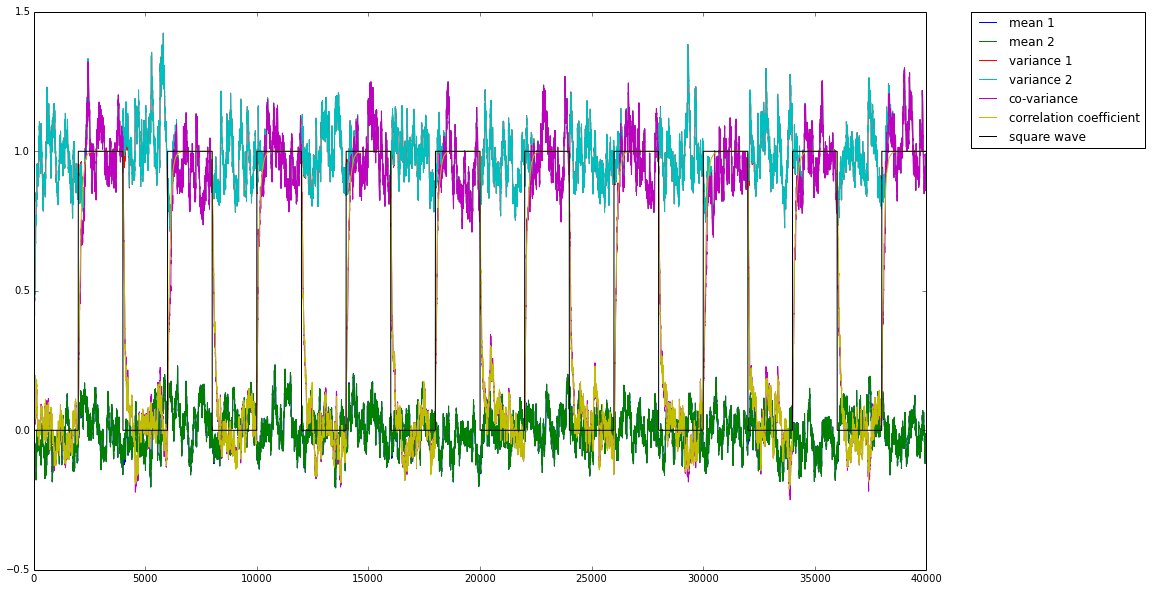

(array([-0.07108938, -0.07949265, -0.08932214, ...,  0.03352535,
         0.03558987,  0.03223127]),
 array([-0.07114725, -0.07954994, -0.08937886, ...,  0.0226154 ,
         0.03345286,  0.03551811]),
 array([ 0.96744367,  0.96469021,  0.96451294, ...,  0.98896597,
         0.97949405,  0.97080469]),
 array([ 0.96745597,  0.96470142,  0.96452294, ...,  0.98734345,
         0.98898135,  0.97950957]),
 array([ 0.96055837,  0.95787328,  0.95776362, ..., -0.00876661,
        -0.00648605, -0.00710102]),
 array([ 0.99287668,  0.99292778,  0.99299721, ..., -0.0088717 ,
        -0.00659   , -0.007282  ]))

In [23] used 0.8594 MiB RAM in 5.57s, peaked 16.90 MiB above current, total RAM usage 540.95 MiB


In [23]:
exp_decay(40000, 0.01, 1, 0)

In [11]:
exp_decay(10**3, 0.01, 0, 0)

(array([ -3.73970348e-03,  -9.30118342e-03,   7.50333250e-03,
          7.64553135e-03,   1.84655971e-02,   3.28828902e-02,
          3.56722579e-02,   4.02789438e-02,   5.45079718e-02,
          4.74051146e-02,   4.40178419e-02,   4.58993205e-02,
          4.93366691e-02,   4.91381293e-02,   3.37904438e-02,
          2.81252290e-02,   2.43968925e-02,   4.50311752e-02,
          4.38378467e-02,   1.70028854e-02,   8.25619898e-04,
         -9.98172055e-03,  -9.71881587e-03,  -2.47203199e-02,
         -3.78636122e-02,  -5.38872062e-02,  -4.50192074e-02,
         -2.37607638e-02,  -1.02535686e-02,  -2.24609211e-02,
         -2.81171565e-02,  -4.72446966e-02,  -3.71413196e-02,
         -3.74636147e-02,  -3.62449480e-02,  -4.12743558e-02,
         -3.13825789e-02,  -4.21070591e-02,  -3.59652177e-02,
         -3.91520291e-02,  -3.64870972e-02,  -4.65769847e-02,
         -4.69625377e-02,  -4.22534440e-02,  -6.88631222e-02,
         -7.17954108e-02,  -6.89715372e-02,  -7.17292641e-02,
        

In [11] used 0.4648 MiB RAM in 0.24s, peaked 0.00 MiB above current, total RAM usage 88.81 MiB


In [6]:
exp_decay(10**4, 0.01, 0, 0)

(array([-0.0037397 , -0.00930118,  0.00750333, ..., -0.06212707,
        -0.07138059, -0.07129362]),
 array([-0.00300271, -0.00671238, -0.01224414, ..., -0.05441457,
        -0.06212707, -0.07138059]),
 array([ 0.00137071,  0.00438846,  0.03202179, ...,  0.9443816 ,
         0.94333014,  0.93389758]),
 array([  8.83683264e-04,   2.22363055e-03,   5.20052892e-03, ...,
          9.48032026e-01,   9.44381598e-01,   9.43330137e-01]),
 array([ 0.00110058,  0.00311164, -0.00603033, ...,  0.08745106,
         0.0935713 ,  0.09255672]),
 array([ 1.        ,  0.99609977, -0.4672985 , ...,  0.09242295,
         0.09913729,  0.09861125]))

In [6] used 0.5156 MiB RAM in 0.12s, peaked 0.00 MiB above current, total RAM usage 73.89 MiB


In [5]:
exp_decay(10**5, 0.01, 0, 0)

(array([-0.0037397 , -0.00930118,  0.00750333, ...,  0.02771884,
         0.02250054,  0.04014231]),
 array([-0.00300271, -0.00671238, -0.01224414, ...,  0.02771884,
         0.02250054,  0.04014231]),
 array([ 0.00137071,  0.00438846,  0.03202179, ...,  1.03755358,
         1.02984692,  1.05005229]),
 array([  8.83683264e-04,   2.22363055e-03,   5.20052892e-03, ...,
          1.03755358e+00,   1.02984692e+00,   1.05005229e+00]),
 array([ 0.00110058,  0.00311164, -0.00603033, ...,  1.03755358,
         1.02984692,  1.05005229]),
 array([ 1.        ,  0.99609977, -0.4672985 , ...,  1.        ,
         1.        ,  1.        ]))

In [5] used 7.6836 MiB RAM in 0.15s, peaked 0.00 MiB above current, total RAM usage 65.35 MiB


In [4]:
exp_decay(10**6, 0.01, 0, 0)

(array([-0.0037397 , -0.00930118,  0.00750333, ..., -0.02402985,
        -0.02784958, -0.0427564 ]),
 array([-0.00300271, -0.00671238, -0.01224414, ..., -0.02402984,
        -0.02784958, -0.04275639]),
 array([ 0.00137071,  0.00438846,  0.03202179, ...,  0.92688255,
         0.91904373,  0.93163239]),
 array([  8.83683264e-04,   2.22363055e-03,   5.20052892e-03, ...,
          9.26882550e-01,   9.19043730e-01,   9.31632394e-01]),
 array([ 0.00110058,  0.00311164, -0.00603033, ...,  0.9268822 ,
         0.91904339,  0.93163205]),
 array([ 1.        ,  0.99609977, -0.4672985 , ...,  0.99999963,
         0.99999963,  0.99999964]))

In [4] used 76.3594 MiB RAM in 0.24s, peaked 7.63 MiB above current, total RAM usage 134.23 MiB


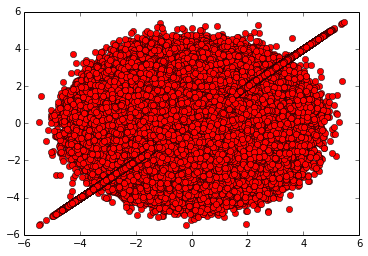

In [7] used 2.2930 MiB RAM in 194.88s, peaked 3359.65 MiB above current, total RAM usage 2216.93 MiB


In [7]:
import matplotlib.pyplot as plt
n=10**8
f1=open('data1.bin','rb')
f2=open('data2.bin','rb')
input1=np.fromfile(f1,count=n)
input2=np.fromfile(f2,count=n)
plt.plot(input1, input2, 'ro')
plt.show()

Part 1:
This note book provide 2 approaches to calculate the mean, variance, covariance and correlation coefficient using numpy and chunking. These two methods has been mentioned above. The mean is 0, and the variance is 1, and the covariance is 0.5 and correlation coefficient is 0.5.

Part 2:
The best chunk size for the streaming method is about 10^5 and the best chunk size for the exponential decay method is about 10^4 based on the the execution time. A reasonable $\alpha$ is 0.01, considering the the waveform and the local statistics converage to the global statistics.

part 3: 
It has been discussed in the previous parts.

part 4: 
The positions is print out in the following cell, and the delay is 500 every time. In most time, the period is 4000. Every 708500 data points, there is a 500 delay.

In [15]:
cyc_thres=int(1.1*4000)
n=10**8
f1=open('data1.bin','rb')
f2=open('data2.bin','rb')
seq1=np.zeros(n)
seq2=np.zeros(n)
seq1=np.fromfile(f1,count=n)
seq2=np.fromfile(f2,count=n)
sz=np.size(seq1)
pre=0
cur=0
last_delay=0
for i in range(sz-2):
    if(seq1[i]!=seq2[i] and seq1[i+1]==seq2[i+1]):
        cur=i
        if((cur-pre)>cyc_thres): #find a delay in the sequencee
            print (cur+1)
        pre=cur

710500
1419000
2127500
2836000
3544500
4253000
4961500
5670000
6378500
7087000
7795500
8504000
9212500
9921000
10629500
11338000
12046500
12755000
13463500
14172000
14880500
15589000
16297500
17006000
17714500
18423000
19131500
19840000
20548500
21257000
21965500
22674000
23382500
24091000
24799500
25508000
26216500
26925000
27633500
28342000
29050500
29759000
30467500
31176000
31884500
32593000
33301500
34010000
34718500
35427000
36135500
36844000
37552500
38261000
38969500
39678000
40386500
41095000
41803500
42512000
43220500
43929000
44637500
45346000
46054500
46763000
47471500
48180000
48888500
49597000
50305500
51014000
51722500
52431000
53139500
53848000
54556500
55265000
55973500
56682000
57390500
58099000
58807500
59516000
60224500
60933000
61641500
62350000
63058500
63767000
64475500
65184000
65892500
66601000
67309500
68018000
68726500
69435000
70143500
In [15] used 0.0156 MiB RAM in 51.75s, peaked 540.54 MiB above current, total RAM usage 3033.62 MiB
